In [1]:
#imports
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, load_img, img_to_array
import numpy as np

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense

In [2]:
#Data Generator for Data augmentation. Edit possible
train_datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

In [3]:
#Sanity check for augmentation

img = load_img('../datasets/large_sample/almond_desert/6350.jpg')  # this is a PIL image
img=img.resize((150,150))
x = img_to_array(img)  # this is a Numpy array with shape (3, 150, 150)
print(x.shape)
x = x.reshape((1,) + x.shape)  # this is a Numpy array with shape (1, 3, 150, 150)

# the .flow() command below generates batches of randomly transformed images
# and saves the results to the `preview/` directory
i = 0
for batch in train_datagen.flow(x, batch_size=1,
                          save_to_dir='preview', save_prefix='almond_desert', save_format='jpeg'):
    i += 1
    if i > 20:
        break  # otherwise the generator would loop indefinitely

(150, 150, 3)


In [4]:
train_generator = train_datagen.flow_from_directory(
        '../datasets/large_sample',  # this is the target directory
        target_size=(150, 150),  # all images will be resized to 150x150
        batch_size=32,
        class_mode='categorical')  # since we use binary_crossentropy loss, we need binary labels

Found 45842 images belonging to 75 classes.


In [5]:
#Naive Model

model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=(150, 150, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(75))
model.add(Activation('sigmoid'))

model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])


In [6]:
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 32)      896       
_________________________________________________________________
activation (Activation)      (None, 148, 148, 32)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 32)        9248      
_________________________________________________________________
activation_1 (Activation)    (None, 72, 72, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 64)        18496     
__________

In [7]:
model.fit_generator(train_generator,
                   steps_per_epoch = 1500,
                   epochs = 1)

Epoch 1/1
1500/1500 [==============================] - 509s 339ms/step - loss: 4.0324 - acc: 0.0506


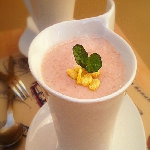

(1, 150, 150, 3)


In [8]:
img = load_img('../datasets/large_sample/almond_desert/6350.jpg')  # this is a PIL image
img=img.resize((150,150))
display(img)
x = img_to_array(img)  # this is a Numpy array with shape (3, 150, 150)
x = x.reshape((1,) + x.shape)  # this is a Numpy array with shape (1, 3, 150, 150)

print(x.shape)

In [12]:

y = model.predict(x)

In [20]:
y

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32)